# Quantum Error Correction Using 3 repetition Codes under Random X, Z Errors

## 3 repetition code overview

Because I am math major, so I want to summerize the key math part of this code as following:

For any computational-basis state $\ket{q_1 q_2}\ket{0}_3$ with $q_i\in\{0,1\}$,

$\mathrm{CNOT}_{1\to 3}\;\mathrm{CNOT}_{2\to 3}\;\ket{q_1 q_2}\ket{0}_3
=\ket{q_1 q_2}\ket{\,q_1 \oplus q_2\,}_3 .$

Thus the ancilla records the XOR (parity) $q_1\oplus q_2$.
Because $\ket{q_i}$ are $Z$-eigenstates with eigenvalues
$Z\ket{q_i}=(-1)^{q_i}\ket{q_i}$, this is equivalent to measuring the
stabilizer $Z_1Z_2$:
$\lambda(Z_1Z_2)=(-1)^{q_1\oplus q_2}
=\begin{cases}
+1,& \text{parity }0,\\
-1,& \text{parity }1~.
\end{cases}$

Suppose some number of bit flips occur on qubits $1,2,3$.
Write the error as
$ E = X_1^{e_1} X_2^{e_2} X_3^{e_3},e_i\in\{0,1\}.$

By linearity, the error hits both branches of the superposition:
$ E\ket{\psi}
=\alpha\,\ket{e_1 e_2 e_3}
+\beta\,\ket{\bar e_1 \bar e_2 \bar e_3},
\bar e_i = e_i \oplus 1.$

Compute the XOR for each branch:
$\begin{cases}
\text{first branch: }~ e_1\oplus e_2,\\
\text{second branch: }~ \bar e_1\oplus \bar e_2
= (e_1\oplus 1)\oplus (e_2\oplus 1)
= e_1\oplus e_2.
\end{cases}$

They are the same. Therefore the measurement outcome of $Z_1Z_2$
depends only on the error pattern $(e_1,e_2,e_3)$, not on which
logical basis element ($\ket{000}$ or $\ket{111}$) is chosen from the
superposition, nor on the amplitudes $\alpha,\beta$.


## Step1: Logical zero state preparation

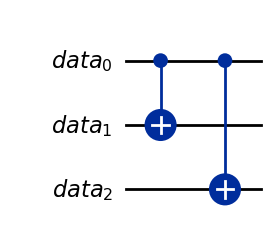

In [9]:
from qiskit import QuantumCircuit, QuantumRegister

def prepare_logical_zero():
    data_qubits = QuantumRegister(3, 'data')
    qc = QuantumCircuit(data_qubits)

# Explicitly apply CNOT gates as per stabilizer matrix
    stabilizer_pairs = [     
        (0,1), (0,2)
    ]

# Apply the CNOT gates explicitly
    for control, target in stabilizer_pairs:
        qc.cx(data_qubits[control], data_qubits[target])

    return qc

# Print
logical_zero_circuit = prepare_logical_zero()
logical_zero_circuit.draw('mpl')

## Step2: Implement random X, Z noise model

1. Define the Error Probabilities:

- No error: $1-(a+b)$

- X errors: $a$

- Z errors: $b$

2. Construct the QuantumError:

3. Apply the QuantumError to all single-qubit gates (excluding multi-qubit gates like cx).


In [10]:
from qiskit_aer.noise import NoiseModel, pauli_error

def make_xz_noise_model(a: float, b: float) -> NoiseModel:
    if a < 0 or b < 0 or a + b > 1:
        raise ValueError("Require a >= 0, b >= 0, and a+b <= 1.")
    single = pauli_error([('X', a), ('Z', b), ('I', 1 - a - b)])
    twoq  = single.tensor(single)  # independent channel on control ⊗ target

    noise = NoiseModel()
    # add to typical 1q native gates (your circuit uses only H and CX; H will be decomposed)
    noise.add_all_qubit_quantum_error(single, ['rz', 'sx', 'x'])
    # add to every CX
    noise.add_all_qubit_quantum_error(twoq, ['cx'])
    return noise

# Example
example_noise_model = make_xz_noise_model(a=0.05, b=0.0)  # pure bit-flip, 5%
print(example_noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['rz', 'x', 'cx', 'sx']
  All-qubits errors: ['rz', 'sx', 'x', 'cx']


## Step3:Syndrome measurement
- Ancilla qubits collect parity information.
- Measuring the ancillas gives the syndrome.
- Syndromes detect bit-flip (X) errors using Z-type stabilizers.
- Syndromes detect phase-flip (Z) errors using X-type stabilizers.

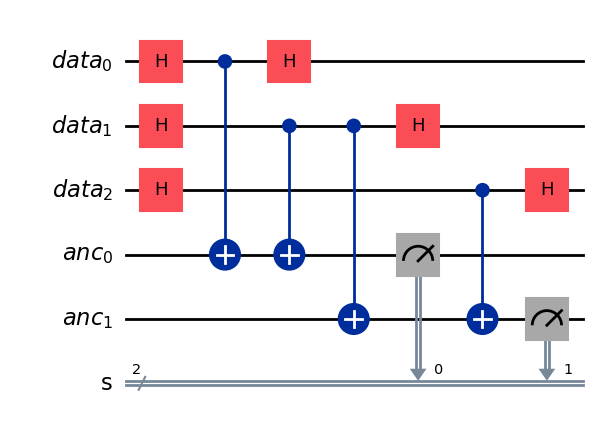

In [25]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def repetition3_syndrome_circuit(error_type='X'):
    """
    3-qubit repetition code syndrome extraction.

    error_type:
      'X' -> detect X errors via Z-parities Z1Z2, Z2Z3
      'Z' -> detect Z errors by H-rotate data, measure X1X2, X2X3, H back
    """
    # 3 data qubits, 2 ancillas, 2 classical bits for syndrome
    data = QuantumRegister(3, 'data')
    anc  = QuantumRegister(2, 'anc')
    syn  = ClassicalRegister(2, 's')
    qc = QuantumCircuit(data, anc, syn, name=f"rep3_{error_type}_syndrome")

    # For Z-error detection, change basis on DATA (H Z H = X)
    if error_type.upper() == 'Z':
        qc.h(data[0])
        qc.h(data[1])
        qc.h(data[2])

    # ---- parity checks ----
    # anc[0] measures parity of (data[0], data[1])
    qc.cx(data[0], anc[0])
    qc.cx(data[1], anc[0])

    # anc[1] measures parity of (data[1], data[2])
    qc.cx(data[1], anc[1])
    qc.cx(data[2], anc[1])

    # Rotate back if we changed basis for Z-error detection
    if error_type.upper() == 'Z':
        qc.h(data[0])
        qc.h(data[1])
        qc.h(data[2])

    # Measure ancillas to read the syndrome
    qc.measure(anc[0], syn[0])  # syndrome for pair (1,2)
    qc.measure(anc[1], syn[1])  # syndrome for pair (2,3)

    return qc, data, syn

# Examples:
qcX, dataX, synX = repetition3_syndrome_circuit('X')
qcZ, dataZ, synZ = repetition3_syndrome_circuit('Z')

# Draw
# qc_X.draw('mpl')
qcZ.draw('mpl')

## Step4: Error correction
- Syndrome results
- Look up recovery map
- Apply recovery 

$(s_0, s_1) = (1, 0)$ means error on first qubit

$(s_0, s_1) = (1, 1)$ means error on second qubit

$(s_0, s_1) = (0, 1)$ means error on third qubit

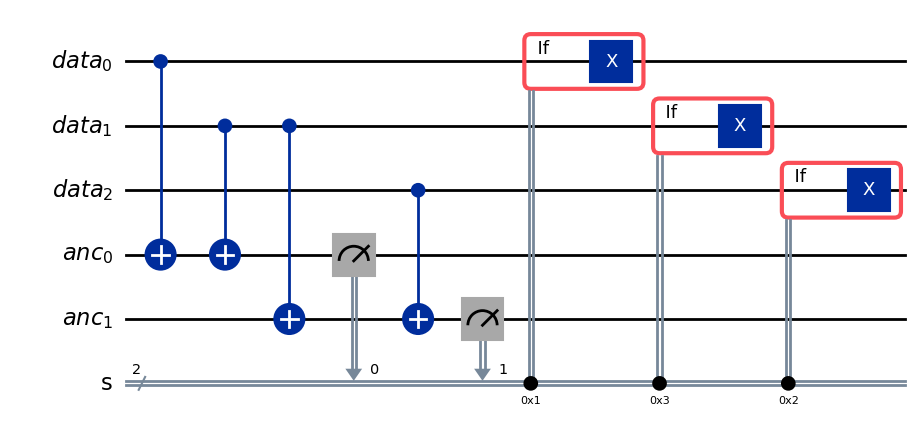

In [26]:
def apply_recovery(qc, data_qubits, syndrome_bits, syndrome_recovery_map):
    """
    Apply conditional single-qubit Pauli corrections based on a 2-bit syndrome.
    syndrome_recovery_map maps '00','01','11','10' -> (qubit_index, 'X'/'Y'/'Z') or None.
    """
    for s, action in syndrome_recovery_map.items():
        if action is None:
            continue
        qidx, pauli = action
        cond = int(s, 2)  # e.g. '11' -> 3

        # Run these gates only if the measured syndrome equals `cond`
        with qc.if_test((syndrome_bits, cond)):
            if pauli == 'X':
                qc.x(data_qubits[qidx])
            elif pauli == 'Z':
                qc.z(data_qubits[qidx])


# ---------- X-error case ----------
qcX, dataX, synX = repetition3_syndrome_circuit('X')

# Your requested mapping for X errors:
x_recovery_map = {
    '00': None,         # no error
    '01': (0, 'X'),     # error on data[0]
    '11': (1, 'X'),     # error on data[1]
    '10': (2, 'X'),     # error on data[2]
}
apply_recovery(qcX, dataX, synX, x_recovery_map)

# ---------- Z-error case ----------
qcZ, dataZ, synZ = repetition3_syndrome_circuit('Z')

# Same pattern but using Z corrections
z_recovery_map = {
    '00': None,
    '01': (0, 'Z'),
    '11': (1, 'Z'),
    '10': (2, 'Z'),
}
apply_recovery(qcZ, dataZ, synZ, z_recovery_map)

# Draw (pick one)
qcX.draw('mpl')  # syndrome + conditional X recovery
# qcZ.draw('mpl')  # syndrome + conditional Z recovery

##

## Conclusion: 3-repetition code couldn't correct X or Z errors simultaneously.